In [ ]:
!pip freeze | grep qiskit

qiskit==0.44.0
qiskit-aer==0.12.0
qiskit-terra==0.25.0


In [ ]:
!pip install 'numpy<2' pylatexenc

In [1]:
from qiskit import QuantumCircuit, pulse, transpile, schedule, Aer
from qiskit.visualization.pulse_v2 import IQXDebugging
from qiskit.providers.fake_provider import *
from qiskit.pulse.library import Gaussian
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
simulator = Aer.get_backend('aer_simulator_statevector')
backend = FakeValencia()

In [3]:
backend_config=backend.configuration()
backend_config.basis_gates

['id', 'rz', 'sx', 'x', 'cx']

# Calling aer_simulator, and FakeValencia()

In [4]:
backend_config.open_pulse

True

In [5]:
dt=backend_config.dt
print(f"{dt*1e9} ns")

0.2222222222222222 ns


# Let's look at pulse schedule of X gate

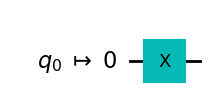

In [6]:
circ=QuantumCircuit(1)
circ.x(0)
circ_trans=transpile(circ,backend)
circ_trans.draw(idle_wires=False,output='mpl')

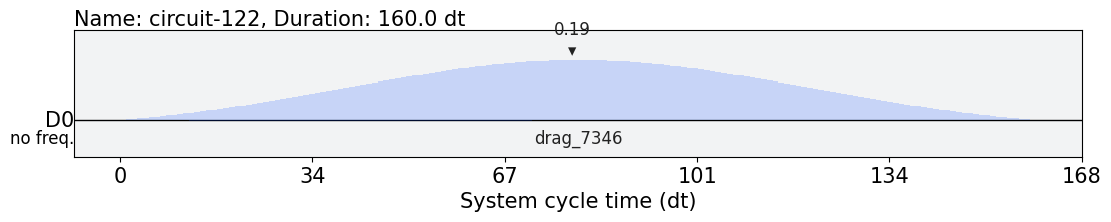

In [7]:
circ_sched=schedule(circ_trans,backend)
#circ_sched.draw()
circ_sched.draw(IQXDebugging())

In [8]:
circ_sched.filter(channels=[pulse.DriveChannel(0)])

Schedule((0, Play(Drag(duration=160, sigma=40, beta=-0.25388969010654494, amp=0.19290084722113582, angle=0.0, name='drag_7346'), DriveChannel(0), name='drag_7346')), name="circuit-122")

### Derivative Removal by Adiabatic Gate Pulse

# Let's look at H gate

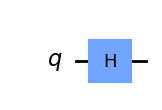

In [9]:
circ = QuantumCircuit(1)
circ.h(0)
circ.draw('mpl')

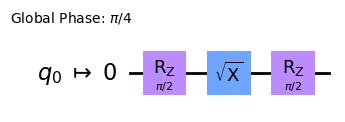

In [10]:
transpile_circ=transpile(circ, backend)
transpile_circ.draw(output='mpl', idle_wires=False)


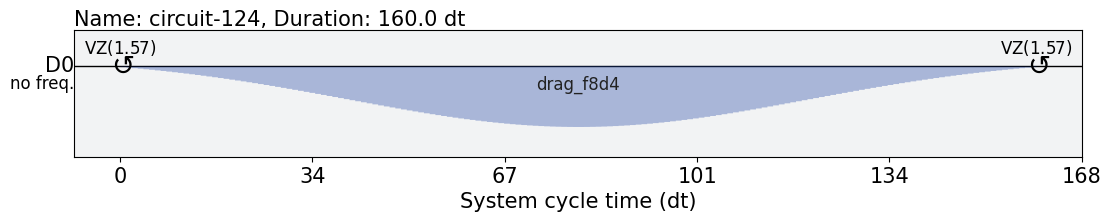

In [11]:
schedule_circ=schedule(transpile_circ, backend)
schedule_circ.draw()


In [12]:
schedule_circ.filter(channels=[pulse.DriveChannel(0)])

Schedule((0, ShiftPhase(-1.5707963268, DriveChannel(0))), (0, Play(Drag(duration=160, sigma=40, beta=-0.35835396095069005, amp=0.0961922281523014, angle=0.008783280252964184, name='drag_f8d4'), DriveChannel(0), name='drag_f8d4')), (160, ShiftPhase(-1.5707963268, DriveChannel(0))), name="circuit-124")

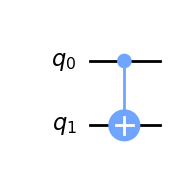

In [13]:
qc=QuantumCircuit(2)
#qc.h(0)
qc.cx(0,1)
qc.draw(output='mpl')

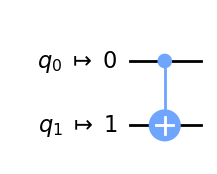

In [14]:
qc_tra=transpile(qc,backend)
qc_tra.draw(output='mpl',idle_wires=False)

The CR gate is microwave only two qubit entangling gate for fixed frequency dispersively coupled. It is physically realised by driving the control qubit with tmicrowave pulses at the frequency of the target qubit to stimulate the evolution of an effective ZX interaction hamiltonian. This is Z $\otimes $ X

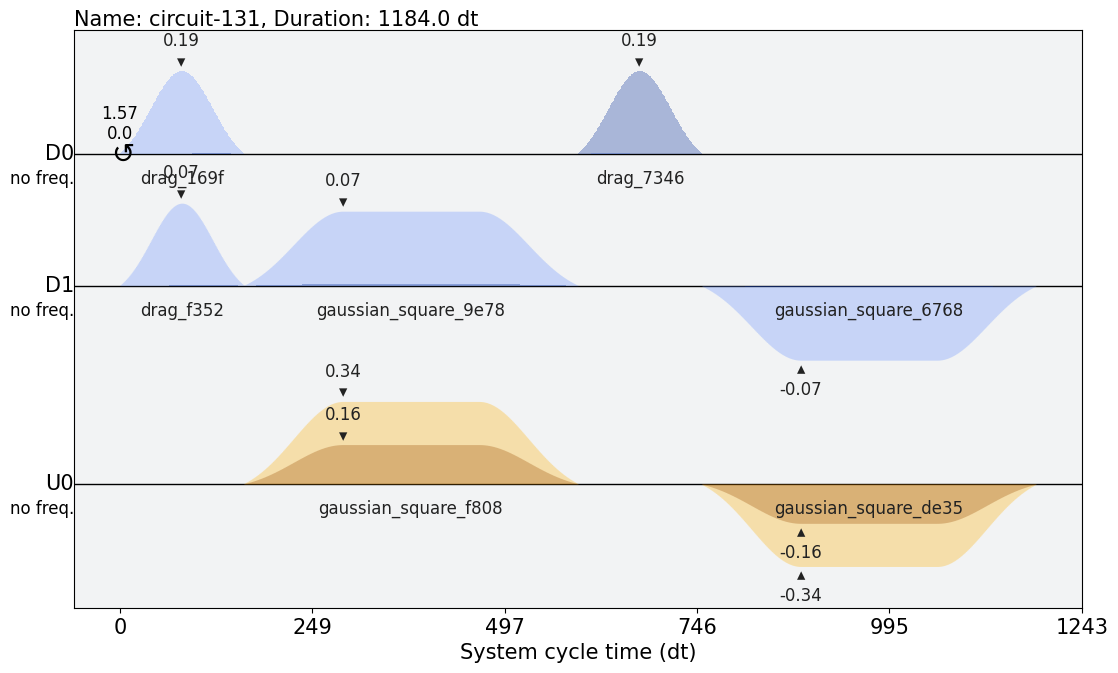

In [15]:
qc_sch=schedule(qc_tra,backend)
qc_sch.draw()
qc_sch.draw(IQXDebugging())

# **Let's look at a Z gate**

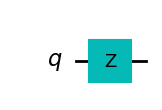

In [16]:
circ=QuantumCircuit(1)
circ.z(0)
circ.draw(output='mpl')

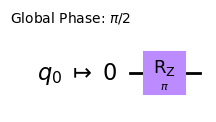

In [17]:
circ_trans=transpile(circ, backend)
circ_trans.draw(idle_wires=False, output = 'mpl')

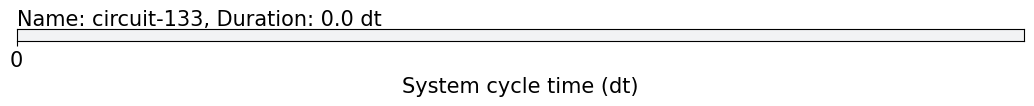

In [18]:
circ_schedule=schedule(circ_trans, backend)
circ_schedule.draw()

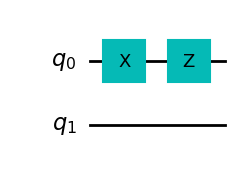

In [19]:
circ=QuantumCircuit(2)
circ.x(0)
circ.z(0)
#circ.cx(0,1)
circ.draw(output='mpl')

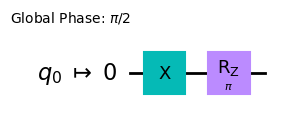

In [20]:
circ_transpile=transpile(circ, backend)
circ_transpile.draw(idle_wires=False, output = 'mpl')

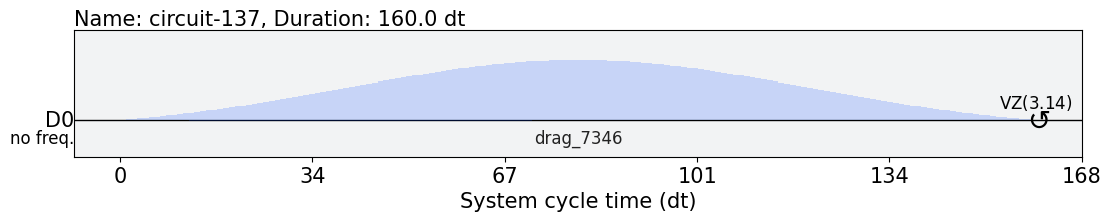

In [21]:
circ_schedule=schedule(circ_transpile, backend)
circ_schedule.draw()

In [22]:
schedule_circ.filter(channels=[pulse.DriveChannel(0)])

Schedule((0, ShiftPhase(-1.5707963268, DriveChannel(0))), (0, Play(Drag(duration=160, sigma=40, beta=-0.35835396095069005, amp=0.0961922281523014, angle=0.008783280252964184, name='drag_f8d4'), DriveChannel(0), name='drag_f8d4')), (160, ShiftPhase(-1.5707963268, DriveChannel(0))), name="circuit-124")

Let's go back to the slides and discuss this weird Z gate behaviour

# Scheduling Method

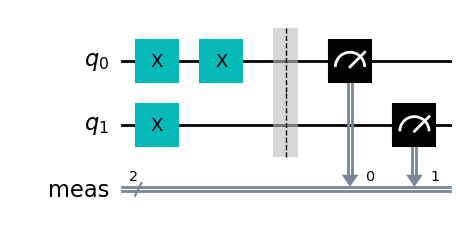

In [23]:
circ = QuantumCircuit(2)
circ.x(0)
circ.x(0)
circ.x(1)
#circ.measure([0, 1], [0, 1])
circ.measure_all()
circ.draw("mpl")


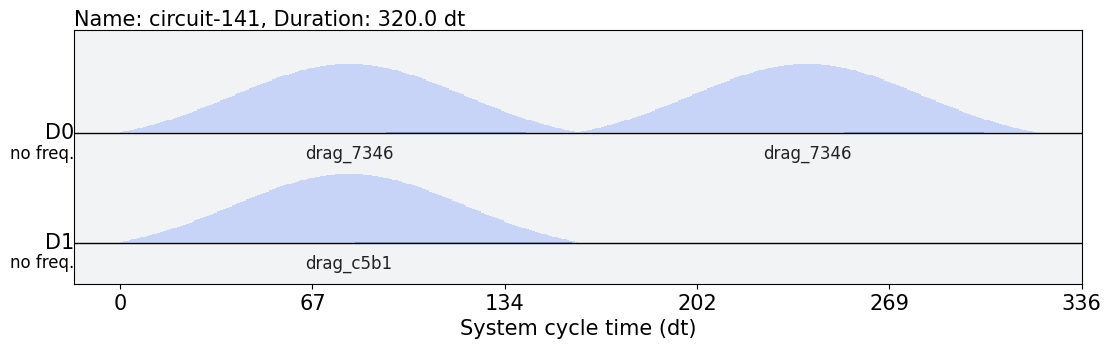

In [24]:
sch = schedule(circ, backend, method="as_soon_as_possible")
sch.filter(channels=[pulse.DriveChannel(0), pulse.DriveChannel(1)]).draw()
# job=backend.run(sch, shots = 20000)
# counts=job.result().get_counts()
# plot_histogram(counts)

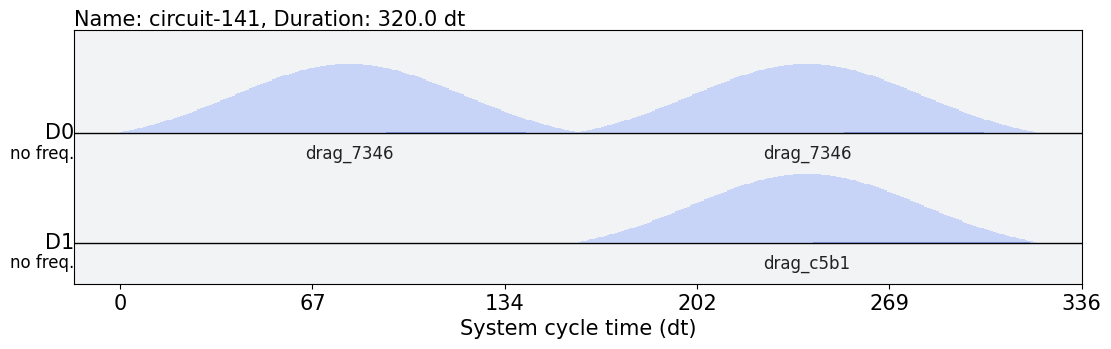

In [25]:


scheduled_circ = schedule(circ, backend, method="as_late_as_possible")
scheduled_circ.filter(channels=[pulse.DriveChannel(0), pulse.DriveChannel(1)]).draw()
# job=backend.run(scheduled_circ, shots = 20000)
# counts=job.result().get_counts()
# plot_histogram(counts)


# Let's calibrate a gate, and compare it with native gate X

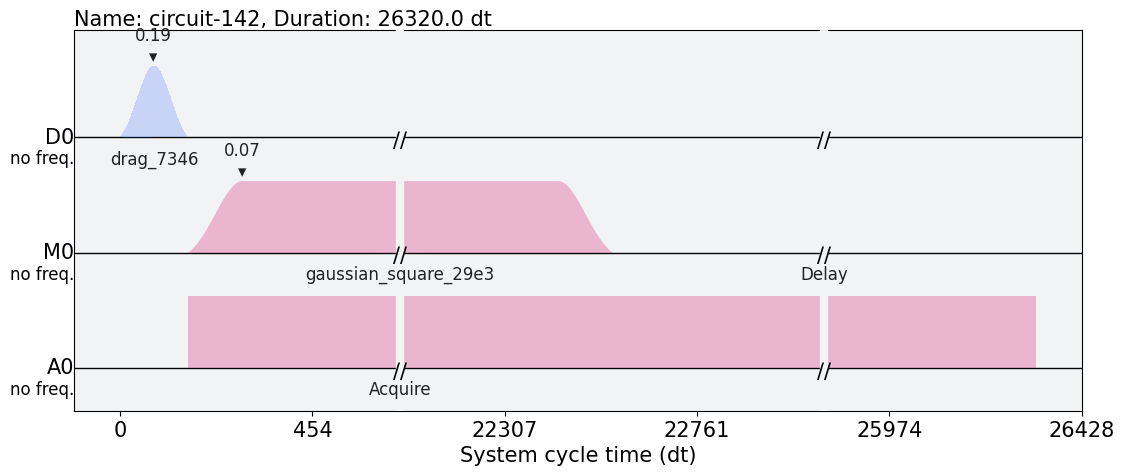

In [26]:
import numpy as np
circ=QuantumCircuit(1,1)
circ.x(0)
circ.measure(0,0)
transpile_x=transpile(circ, backend)
schedule_x=schedule(circ, backend)
schedule_x.draw(IQXDebugging())

In [27]:
schedule_x.filter(channels=[pulse.DriveChannel(0)])

Schedule((0, Play(Drag(duration=160, sigma=40, beta=-0.25388969010654494, amp=0.19290084722113582, angle=0.0, name='drag_7346'), DriveChannel(0), name='drag_7346')), name="circuit-142")

In [28]:
qc=QuantumCircuit(1)
qc.x(0)
qc.measure_all()
job=backend.run(transpile(qc,backend), shots=2*13)
original_counts=job.result().get_counts()   #running it on fake backend

In [29]:
sim_job=simulator.run(transpile(qc,backend), shots=2*13) #running it on simulator
ideal_counts=sim_job.result().get_counts()

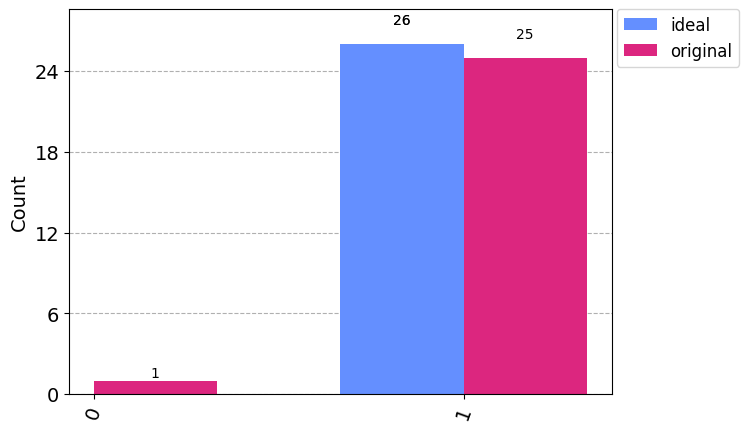

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram([ideal_counts,original_counts], legend=['ideal','original'])

We will create a custom gate. 

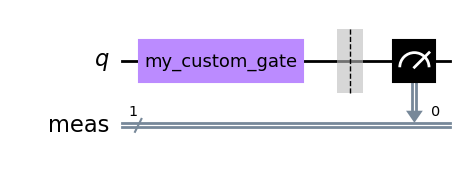

In [31]:
from qiskit.circuit import Gate, Parameter
amp=Parameter('amp')      ##Parameterizing amplitude
circ=QuantumCircuit(1)
custom_gate=Gate('my_custom_gate',1,[])
circ.append(custom_gate,[0])
circ.measure_all()
circ.draw('mpl')

We will build the the pulse schedule for our custom gate

In [32]:
i=.5+.2j
from qiskit.pulse.library import Drag
with pulse.build(backend, name='custom') as my_sched:
    pulse.play(Drag(duration=160, amp=amp, sigma =40,beta=-0.25388969010654494),pulse.drive_channel(0))
    my_sched.assign_parameters({amp:i})

In [33]:
circ.add_calibration(custom_gate, [0], my_sched)

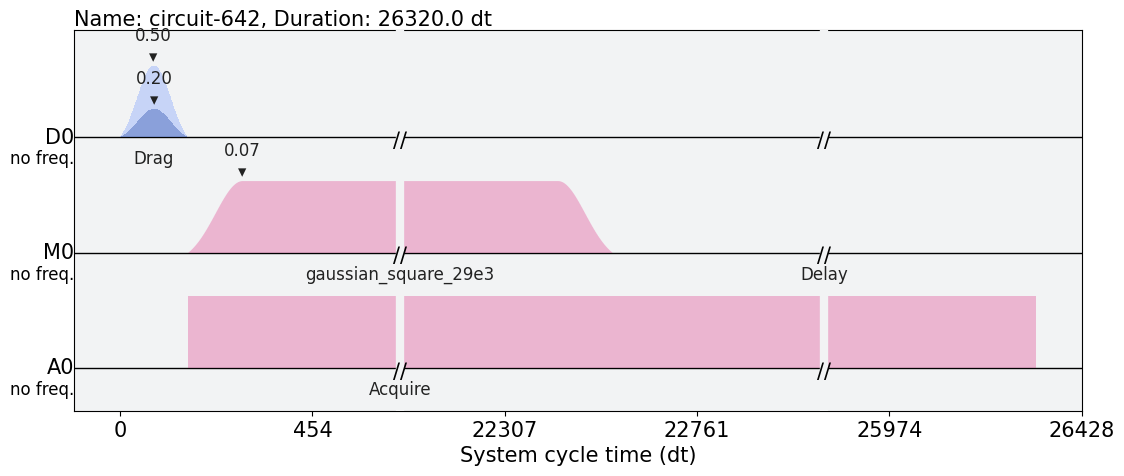

In [34]:
circ_trans=transpile(circ, backend)
circ_sched=schedule(circ_trans, backend)
circ_sched.draw(style=IQXDebugging())

This output was with a random value of amplitude. This gives poor results as compared to the backend_basic_gate. We will optimize the gate with an amplitude sweep.

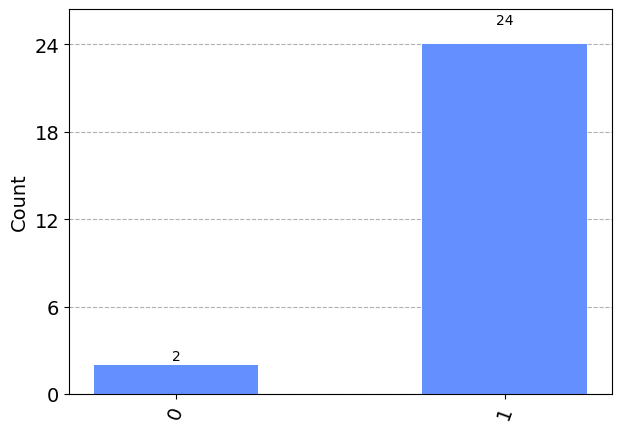

In [35]:
job=backend.run(circ_sched, shots = 2*13)
counts=job.result().get_counts()
plot_histogram(counts)

Creating an amp_optimization function that I will call using minimize_scalar from scipy module

In [36]:
def amp_optimizing(parameter):
    amp=Parameter('amp')
    circ=QuantumCircuit(1)
    custom_gate=Gate('my_custom_gate',1,[])
    circ.append(custom_gate,[0])
    circ.measure_all()

    with pulse.build(backend, name='custom') as my_schedule:
        pulse.play(Drag(duration=160, amp=amp, sigma=40, beta=-0.25388969010654494),pulse.drive_channel(0))
    my_schedule.assign_parameters({amp:parameter})
    circ.add_calibration(custom_gate, [0], my_schedule)

    circ_transpile=transpile(circ, backend)
    schedule_circ=schedule(circ_transpile, backend)
    job=backend.run(schedule_circ, meas_level=1, meas_return='avg', shots=2*13)

    counts=job.result().get_counts()

    if '0' in counts:
        return(counts['0'])/1024
    else:
        return 0


In [37]:
from scipy.optimize import minimize_scalar
res=minimize_scalar(amp_optimizing, bounds=(0.1,0.2), method='bounded')
print(f"Optimum performance is found at {res.x}")

Optimum performance is found at 0.16692757978077954


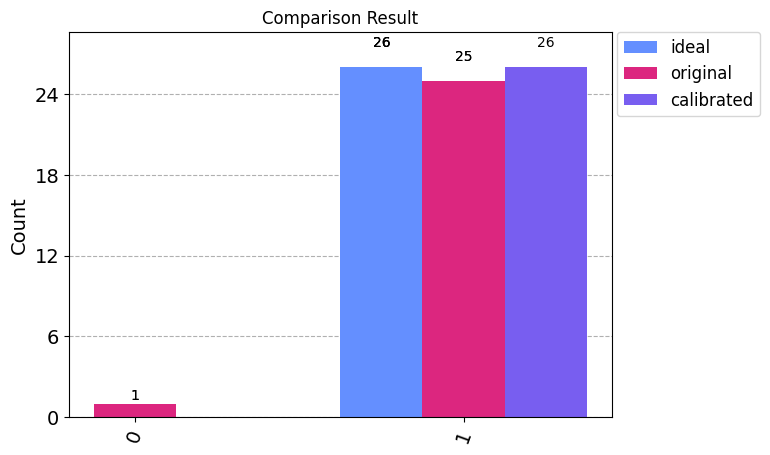

In [38]:
amp=Parameter('amp')
circ=QuantumCircuit(1)
custom_gate= Gate('my_custom_gate',1,[])
circ.append(custom_gate,[0])
circ.measure_all()

with pulse.build(backend, name='custom') as best_x_sched:
    pulse.play(Drag(duration=160, amp=amp, sigma =40,beta=-0.25388969010654494),pulse.drive_channel(0))

best_x_sched.assign_parameters({amp:res.x})
circ.add_calibration(custom_gate,[0],best_x_sched)
circ_transpile= transpile(circ, backend)
schedule_circ=schedule(circ_transpile, backend)

job=backend.run(schedule_circ, shots = 2*13)
calibrated_counts=job.result().get_counts()
plot_histogram([ideal_counts,original_counts,calibrated_counts ], legend=['ideal','original','calibrated'], title="Comparison Result")